# Coherent Semantic Attention - PyTorch Implementation
Student: Klaudia Palak

## Libraries

In [1]:
import time
import torch
from utils.data_load import DataLoad
import os
import torchvision
from torch.utils import data
from torchvision.utils import save_image, make_grid
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Settings

In [2]:
class Opion():
    
    def __init__(self):
            
        self.dataroot= r'E:\magisterka\Datasets\Paris_Street_View_fragment' # image dataroot
        self.maskroot= r'E:\magisterka\Datasets\Maski\mask\testing_mask_dataset'# mask dataroot
        self.batchSize= 64   # Need to be set to 1
        self.fineSize=256 # image size
        self.input_nc=3  # input channel size for first stage
        self.input_nc_g=6 # input channel size for second stage
        self.output_nc=3 # output channel size
        self.ngf=64 # inner channel
        self.ndf=64 # inner channel
        self.which_model_netD='basic' # patch discriminator
        self.which_model_netF='feature'# feature patch discriminator
        self.which_model_netG='unet_csa'# seconde stage network
        self.which_model_netP='unet_256'# first stage network
        self.triple_weight=1
        self.name='CSA_inpainting'
        self.n_layers_D='3' # network depth
        self.gpu_ids=[0]
        self.model='csa_net'
        self.checkpoints_dir=r'E:\magisterka\checkpoints' # checkpoints folder
        self.norm='instance'
        self.fixed_mask=1
        self.use_dropout=False
        self.init_type='normal'
        self.mask_type='center'
        self.lambda_A=100
        self.threshold=5/16.0
        self.stride=1
        self.shift_sz=1 # size of feature patch
        self.mask_thred=1
        self.bottleneck=512
        self.gp_lambda=10.0
        self.ncritic=5
        self.constrain='MSE'
        self.strength=1
        self.init_gain=0.02
        self.cosis=1
        self.gan_type='lsgan'
        self.gan_weight=0.2
        self.overlap=4
        self.skip=0
#         self.display_freq=1000
        self.display_freq = 10
#         self.print_freq=50
        self.print_freq = 2
#         self.save_latest_freq=5000
        self.save_latest_freq = 5
        self.save_epoch_freq=2
        self.continue_train=False
        self.epoch_count=1
        self.phase='train'
        self.which_epoch=''
#         self.niter=20
#         self.niter_decay=100
        self.niter = 2
        self.niter_decay = 4
        self.beta1=0.5
        self.lr=0.0002
        self.lr_policy='lambda'
        self.lr_decay_iters=50
        self.isTrain=True


## Dataset

In [3]:
opt = Opion()
transform_mask = transforms.Compose(
    [transforms.Resize((opt.fineSize,opt.fineSize)),
     transforms.ToTensor(),
    ])
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.Resize((opt.fineSize,opt.fineSize)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

dataset_train = DataLoad(opt.dataroot, opt.maskroot, transform, transform_mask)
iterator_train = (data.DataLoader(dataset_train, batch_size=opt.batchSize,shuffle=True))
print(len(dataset_train))

20


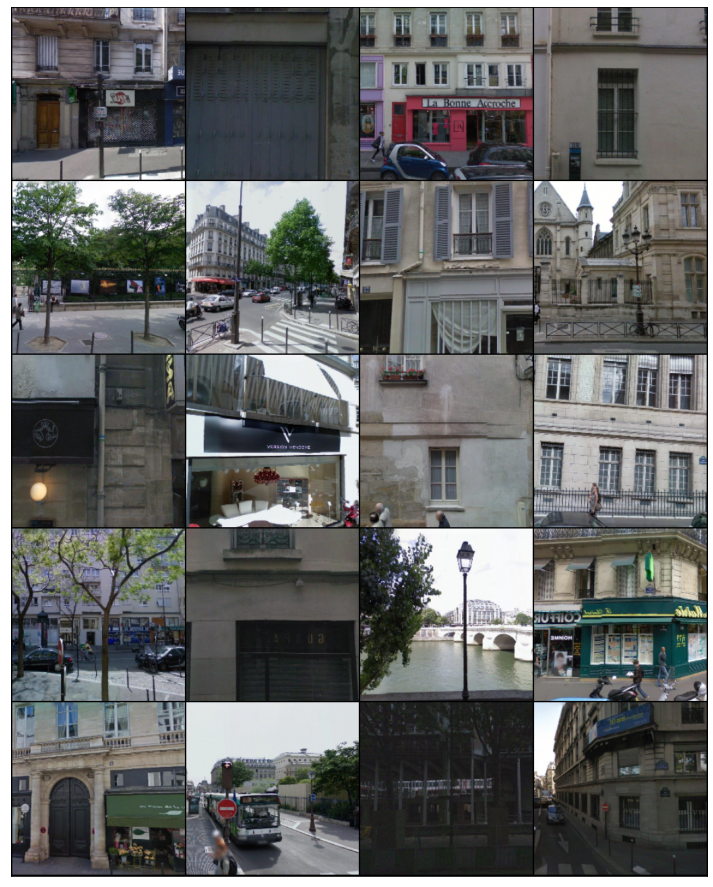

In [4]:
# Data visualization
def imshow(img):
    img = img / 2.0 + 0.5
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((img), nrow=4).permute(1, 2, 0))

dataiter = iter(iterator_train)
images = dataiter.next()

imshow(images[0])

## Model

In [5]:
from models.model import create_model

In [6]:
model = create_model(opt)

csa_net
initialize network with normal


E:\magisterka\Kod\ImageInpainting\models\networks.py:55: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 0.0, gain)
E:\magisterka\Kod\ImageInpainting\models\networks.py:65: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias.data, 0.0)


initialize network with normal
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
UnetGeneratorCSA(
  (model): UnetSkipConnectionBlock_3(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): UnetSkipConnectionBlock_3(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
          (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (6): UnetSkipConnectionBlock_3(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
  

## Training

In [7]:
total_steps = 0
iter_start_time = time.time()
for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    
    epoch_start_time = time.time()
    epoch_iter = 0

#     image, mask, gt = [x.cuda() for x in next(iterator_train)]
    for image, mask in (iterator_train):
        image=image.cuda()
        mask=mask.cuda()
        mask=mask[0][0]
        mask=torch.unsqueeze(mask,0)
        mask=torch.unsqueeze(mask,1)
        mask=mask.byte()

        total_steps += opt.batchSize
        epoch_iter += opt.batchSize
        model.set_input(image,mask) # it not only sets the input data with mask, but also sets the latent mask.
        model.set_gt_latent()
        model.optimize_parameters()

        if total_steps %opt.display_freq== 0:
            real_A,real_B,fake_B=model.get_current_visuals()
            #real_A=input, real_B=ground truth fake_b=output
            pic = (torch.cat([real_A, real_B,fake_B], dim=0) + 1) / 2.0
            torchvision.utils.save_image(pic, '%s/Epoch_(%d)_(%dof%d).jpg' % (
            opt.checkpoints_dir, epoch, total_steps + 1, len(dataset_train)), nrow=2)
        if total_steps %1== 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / opt.batchSize
            print(errors)

    if epoch % opt.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' %
                (epoch, total_steps))
        model.save(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' %
            (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))

    model.update_learning_rate()


E:\magisterka\Kod\ImageInpainting\models\CSA.py:138: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  C:/cb/pytorch_1000000000000/work/aten/src/ATen/native/cuda/Indexing.cu:963.)
  self.input_A.narrow(1, 0, 1).masked_fill_(self.mask_global, 2 * 123.0 / 255.0 - 1.0)
E:\magisterka\Kod\ImageInpainting\models\CSA.py:139: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  C:/cb/pytorch_1000000000000/work/aten/src/ATen/native/cuda/Indexing.cu:963.)
  self.input_A.narrow(1, 1, 1).masked_fill_(self.mask_global, 2 * 104.0 / 255.0 - 1.0)
E:\magisterka\Kod\ImageInpainting\models\CSA.py:140: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internall

RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 4.00 GiB total capacity; 2.76 GiB already allocated; 12.45 MiB free; 2.81 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF